### Import Module

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

### Load Data

In [2]:
data = pd.DataFrame({
    "month":[0,3,4,9,12],
    "pressure":[3500,3000,2500,2000,1500],
    "cumulative":[0,218,461,725,1000]
})
data

,month,pressure,cumulative
0,0,3500,0
1,3,3000,218
2,4,2500,461
3,9,2000,725
4,12,1500,1000


### Functions

In [3]:
def CriticalPT(sg,system='natgas',correction='no', co2_frac=0.00, h2s_frac=0.00, n2_frac=0.00):
    
    #From Tarek Ahmed - Hydrocarbon Phase Behaviour
    
    #For natural gas system
    if system == 'natgas':
        tc = 168 + 325*sg - 12.5*(sg**2)
        pc = 677 + 15.0*sg - 37.5*(sg**2)
    #For gas condensate system
    elif system == 'gascon':
        tc = 187 + 330*sg - 71.5*(sg**2)
        pc = 706 + 51.7*sg - 11.1*(sg**2)
    else:
        raise Exception("Unrecognized system method. Only accept 'natgas' or 'gascon'")
    #Wichert-aziz correction methods
    if correction == 'wichert':
        bval = h2s_frac
        aval = h2s_frac + co2_frac
        eps = 120*(aval**0.9 - aval**1.6) + 15*(bval**0.5 - bval**4)
        tcnew = tc - eps
        pcnew = pc*tcnew/(tc + bval*(1 - bval)*eps)
        return pcnew,tcnew
    #Carr-kobayashi correction methods
    elif correction == 'kobayashi':
        tcnew = tc - 80*co2_frac + 130*h2s_frac - 250*n2_frac
        pcnew = pc + 440*co2_frac + 600*h2s_frac - 170*n2_frac
        return pcnew,tcnew
    elif correction == 'no':
        return pc,tc
    else:
        raise Exception("Unrecognized correction methods. Only accept 'no', 'wichert' or 'kobayashi'")  

In [4]:
def zFactor(ppr,tpr,method='Dranchuk-Abou Kassem'):
    #Papay (1968)
    if method == 'Papay':
        zfactor = 1 - (ppr/tpr)*(0.36748758 - 0.04188423*(ppr/tpr))
        return zfactor
    #Hall-Yarborough (1973)
    elif method == 'Hall-Yarborough':
        ttpr = 1/tpr
        aval = 0.06125*ttpr*np.exp(-1.2*((1 - ttpr)**2))
        bval = ttpr*(14.76 - 9.76*ttpr + 4.58*(ttpr**2))
        cval = ttpr*(90.7 - 242.2*ttpr + 42.4*(ttpr**2))
        dval = 2.18 + 2.82*ttpr
        yval = 0.061
        fval = -1*aval*ppr + (yval + yval**2 + yval**3 - yval**4)/((1 - yval)**3) - bval*(yval**2) + cval*(yval**dval)
        error = 999
        while (abs(fval) > 0.00000001 and error > 0.00000001):
            fval = -1*aval*ppr + (yval + yval**2 + yval**3 - yval**4)/((1 - yval)**3) - bval*(yval**2) + cval*(yval**dval)
            dfval = (1 + 4*yval + 4*(yval**2) - 4*(yval**3) + yval**4)/((1 - yval)**4) - 2*bval*yval + cval*dval*(yval**(dval - 1))
            nyval = yval - fval/dfval
            error = abs(nyval - yval)
            yval = nyval
        zfactor = aval*ppr/yval
        return zfactor
        #Dranchuk - Abbu Kassem (1975)
    elif method == 'Dranchuk-Abou Kassem':
        a = [0.3265, -1.0700, -0.5339, 0.01569, -0.05165, 0.5475, -0.7361, 0.1844, 0.1056, 0.6134, 0.7210]
        rho = 0.27*ppr/tpr
        zfactor = (a[0] + a[1]/tpr + a[2]/(tpr**3) + a[3]/(tpr**4) + a[4]/(tpr**5))*rho + (a[5] + a[6]/tpr + a[7]/(tpr**2))*(rho**2) - a[8]*(a[6]/tpr + a[7]/(tpr**2))*(rho**5) + a[9]*(1+a[10]*(rho**2))*((rho**2)/(tpr**3))*np.exp(-1*a[10]*(rho**2)) + 1
        error = 999
        while (error > 0.0001):
            rho = 0.27*ppr/(zfactor*tpr)
            newzfactor = (a[0] + a[1]/tpr + a[2]/(tpr**3) + a[3]/(tpr**4) + a[4]/(tpr**5))*rho + (a[5] + a[6]/tpr + a[7]/(tpr**2))*(rho**2) - a[8]*(a[6]/tpr + a[7]/(tpr**2))*(rho**5) + a[9]*(1+a[10]*(rho**2))*((rho**2)/(tpr**3))*np.exp(-1*a[10]*(rho**2)) + 1
            error = abs((newzfactor - zfactor)/zfactor)
            zfactor = newzfactor
        return zfactor
        #Dranchuk-Purvis-Robinson (1974)
    elif method == 'Dranchuk-Purvis':
        a = [0.31506237, -1.0467099, -0.57832729, 0.53530771, -0.61232032, -0.10488813, 0.68157001, 0.68446549]
        rho = 0.27*ppr/tpr
        zfactor = 1 + (a[0] + a[1]/tpr + a[2]/(tpr**3))*rho + (a[3] + a[4]/tpr)*(rho**2) + (a[4]*a[5]/tpr)*(rho**5) + (a[6]/(tpr**3))*(rho**2)*(1+a[7]*(rho**2))*np.exp(-1*a[7]*(rho**2))
        error = 999
        while (error > 0.0001):
            rho = 0.27*ppr/(zfactor*tpr)
            newzfactor =  1 + (a[0] + a[1]/tpr + a[2]/(tpr**3))*rho + (a[3] + a[4]/tpr)*(rho**2) + (a[4]*a[5]/tpr)*(rho**5) + (a[6]/(tpr**3))*(rho**2)*(1+a[7]*(rho**2))*np.exp(-1*a[7]*(rho**2))
            error = abs((newzfactor - zfactor)/zfactor)
            zfactor = newzfactor
        return zfactor
        #Hankinson-Thomas-Phillips (1969)
    elif method == 'Hankinson-Phillips':
        if ppr>=0.4 and ppr<5:
            A=[0,0.001290236,0.38193005,0.022199287,0.12215481,-0.015674794,0.027271364,0.023834219,0.43617780]
        elif ppr>=5 and ppr<15:
            A=[0,0.0014507882,0.37922269,0.024181399,0.1812287,0.037905663,0.19845016,0.048911693,0.0631425417]
        c1=A[4]*tpr-A[2]-(A[6]/(tpr**2))
        c2=A[3]*tpr-A[1]
        c3=(A[1]*A[5]*A[7]*(ppr**5))/(tpr**6)
        c4=(A[8]*(ppr**2))/(tpr**2)
        z1=1
        e=1
        while e>(10**-17): 
            z0=z1
            fz=(1/z0)-1+c1*ppr/((z0**2)*(Tpr**2))+c2*(ppr**2)/((z0**3)*(Tpr**3))+c3*(1+(c4/(z0**2)))*np.exp(-c4/(z0**2))
            fzprime=(-z0**(-2))-2*c1*ppr/((z0**3)*(Tpr**2))-3*c2*(ppr**2)/((z0**4)*(Tpr**3))+c3*np.exp(-c4/(z0**2))*((2*c4*(z0**-1))*((z0**-6)+c4*(z0**-8))-(6*(z0**-7)+8*c4*(z0**-9)))
            z1=z0-(fz/fzprime)
            e=np.abs(z1-z0)
        zfactor = z1
        return zfactor
    #Beggs and Brill (1973)
    elif method == 'Beggs and Brill':
        A=1.39*((tpr-0.92)**0.5)-0.36*tpr-0.101
        B=(0.62-0.23*tpr)*ppr+((0.066/(tpr-0.86))-0.037)*(ppr**2)+(0.32/(10**(9*(tpr-1))))*(ppr**2)
        C=0.132-0.32*(np.log10(tpr))
        D=10**(0.3016-0.49*tpr+0.1824*(tpr**2))
        zfactor = A+(1-A)/(np.exp(B))+C*(ppr**D)
        return zfactor
    else :
        raise NameError ("Unrecognized method. The available methods are 'papay', 'hally', 'DAK', 'DPR', 'hankinson', 'beggs' ")

### Input Data

In [5]:
sgg = 0.75
temp = 210 + 460

### Calculations of P/Z

In [6]:
pc, tc = CriticalPT(sgg)
tpr = temp/tc
data['ppr'] = data['pressure']/pc
data['tpr'] = [tpr]*len(data)
z = []
for i in range (len(data)):
    z.append(zFactor(data['ppr'].values[i], data['tpr'].values[i], method='Beggs and Brill'))
data['z'] = z
data['p/z'] = data['pressure']/data['z']

### Curve Fitting

In [7]:
coef = np.polyfit(data['cumulative'], data['p/z'], deg=1)
p_over_z = [i for i in range (0,int(max(data['p/z'])),100)]
gp = [(pz - coef[1])/coef[0] for pz in p_over_z]
print("IGIP : ", gp[0])

IGIP :  1722.5627673660522


### Model Plot

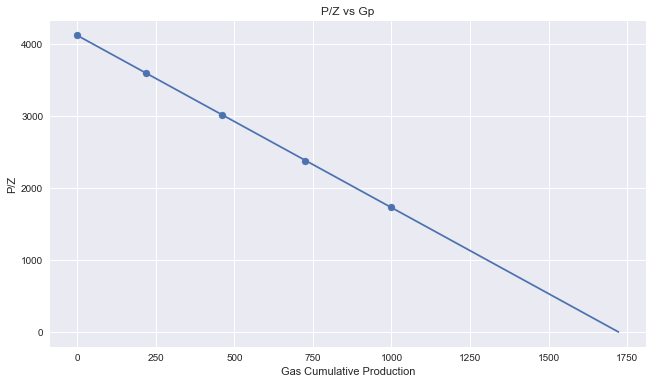

In [8]:
plt.figure(figsize=(16/1.5,9/1.5))
plt.scatter(data['cumulative'], data['p/z'])
plt.plot(gp, p_over_z)
plt.xlabel('Gas Cumulative Production')
plt.ylabel('P/Z')
plt.title('P/Z vs Gp')
plt.show()